# 6. Decision Tree and Ensemble Learning
Exercice issu de ML Zoomcamp 6 [https://github.com/DataTalksClub/machine-learning-zoomcamp/tree/master/06-trees](https://github.com/DataTalksClub/machine-learning-zoomcamp/tree/master/06-trees)
Reprise de son tutoriel avec certaines modifications et commentaires

## 6.1 Credit risk scoring project
* Dataset: https://github.com/gastonstat/CreditScoring

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

## 6.2 Data cleaning and preparation

In [2]:
data_url = 'https://raw.githubusercontent.com/gastonstat/CreditScoring/master/CreditScoring.csv'

In [3]:
import os
filename = 'CreditScoring.csv'
if not os.path.exists(filename):
    os.system(f'wget {data_url} -O {filename}')
    print(f"Le fichier {filename} a été téléchargé avec succès.")
else:
    # Si le fichier existe déjà, imprimez un message
    print(f"Le fichier {filename} existe déjà.")

Le fichier CreditScoring.csv existe déjà.


In [4]:
!head CreditScoring.csv

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
"Status","Seniority","Home","Time","Age","Marital","Records","Job","Expenses","Income","Assets","Debt","Amount","Price"
1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
1,0,1,36,26,1,1,1,46,107,0,0,310,910
1,1,2,60,36,2,1,1,75,214,3500,0,650,1645
1,29,2,60,44,2,1,1,75,125,10000,0,1600,1800
1,9,5,12,27,1,1,1,35,80,0,0,200,1093
1,0,2,60,32,2,1,3,90,107,15000,0,1200,1957


In [5]:
df = pd.read_csv(filename)
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


On remarque que le nom des colonnes du dataset contient des majuscules 

In [6]:
def clean_headers(df:pd.DataFrame)->pd.DataFrame:
    df.columns = df.columns.str.lower().str.replace(' ','_')
    return df

def clean_rows(df:pd.DataFrame)->pd.DataFrame:
    for column in df.columns:
        if pd.api.types.is_string_dtype(df[column]):
            df[column] = df[column].str.lower().str.replace(' ', '_')
    return df

def clean_headers_rows(df:pd.DataFrame)->pd.DataFrame:
    df = clean_headers(df)
    df = clean_rows(df)
    return df

In [7]:
df = clean_headers_rows(df)
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


Il nous manque des informations pour comprendre le dataset, elles sont disponibles sur le github d'où provient de fichier csv. Les voici sous forme de dictionnaire:
status = {0:"unknow", 1:"good", 2:"bad"}
home = {0:"unknow", 1:"rent", 2:"owner", 3:"priv", 4:"ignore", 5:"parents", 6:"other"}
marital = {0:"unknow", 1:"single", 2:"married", 3:"widow", 4:"separated", 5:"divorced"}
records = {0:"unknow", 1:"no_rec", 2:"yes_rec"}
job = {0:"unknow", 1:"fixed", 2:"partime", 3:"freelance", 4:"other"}

On va créer un dataframe lisible pour mieux comprendre les données:

In [8]:
status = {0:"unknow", 1:"good", 2:"bad"}
home = {0:"unknow", 1:"rent", 2:"owner", 3:"priv", 4:"ignore", 5:"parents", 6:"other"}
marital = {0:"unknow", 1:"single", 2:"married", 3:"widow", 4:"separated", 5:"divorced"}
records = {0:"unknow", 1:"no_rec", 2:"yes_rec"}
job = {0:"unknow", 1:"fixed", 2:"partime", 3:"freelance", 4:"other"}

df['status'] = df.status.map(status)
df['home'] = df.home.map(home)
df['marital'] = df.marital.map(marital)
df['records'] = df.records.map(records)
df['job'] = df.job.map(job)


In [9]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,good,9,rent,60,30,married,no_rec,freelance,73,129,0,0,800,846
1,good,17,rent,60,58,widow,no_rec,fixed,48,131,0,0,1000,1658
2,bad,10,owner,36,46,married,yes_rec,freelance,90,200,3000,0,2000,2985
3,good,0,rent,60,24,single,no_rec,fixed,63,182,2500,0,900,1325
4,good,0,rent,36,26,single,no_rec,fixed,46,107,0,0,310,910


Dans les sources, il est indiqué que les valeurs manquantes sont remplacées par le nombre 99999999. Nous devons donc remplacer par np.nan afin de ne pas fausser les résultats

In [10]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


On constate avec la commande ```df.describe().round()``` en valeur **max** nous avons income, assets et debt qui contiennent le nombre 99999999

In [11]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

In [12]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [13]:
df.status.value_counts()

status
good      3200
bad       1254
unknow       1
Name: count, dtype: int64

In [14]:
df = df[df.status != 'unknow'].reset_index(drop=True)

In [15]:
from sklearn.model_selection import train_test_split
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [16]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [17]:
y_train = (df_train.status == 'bad').astype('int').values
y_val = (df_val.status == 'bad').astype('int').values
y_test = (df_test.status == 'bad').astype('int').values

In [18]:
df_train.drop('status', axis=1, inplace=True)
df_val.drop('status', axis=1, inplace=True)
df_test.drop('status', axis=1, inplace=True)

In [19]:
df_train

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,10,owner,36,36,married,no_rec,freelance,75,0.0,10000.0,0.0,1000,1400
1,6,parents,48,32,single,yes_rec,fixed,35,85.0,0.0,0.0,1100,1330
2,1,parents,48,40,married,no_rec,fixed,75,121.0,0.0,0.0,1320,1600
3,1,parents,48,23,single,no_rec,partime,35,72.0,0.0,0.0,1078,1079
4,5,owner,36,46,married,no_rec,freelance,60,100.0,4000.0,0.0,1100,1897
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2667,18,priv,36,45,married,no_rec,fixed,45,220.0,20000.0,0.0,800,1600
2668,7,priv,60,29,married,no_rec,fixed,60,51.0,3500.0,500.0,1000,1290
2669,1,parents,24,19,single,no_rec,fixed,35,28.0,0.0,0.0,400,600
2670,15,owner,48,43,married,no_rec,freelance,60,100.0,18000.0,0.0,2500,2976


## 6.3 Decision trees
* How a decision tree looks like
* Training a decision tree
* Overfitting
* Controlling the size of a tree

In [20]:
#la sortie c'est default ou ok -> sortie binaire
def assess_risk(client):
    if client['records'] == 'yes':
        if client['job'] == 'parttime':
            return 'default'
        else:
            return 'ok'
    else:
        if client['assets'] > 6000:
            return 'ok'
        else:
            return 'default'

In [21]:
xi = df_train.iloc[0].to_dict()

In [22]:
assess_risk(xi)

'ok'

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

In [24]:
train_dicts = df_train.fillna(0).to_dict(orient='records')

In [25]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [26]:
dv.get_feature_names_out()

array(['age', 'amount', 'assets', 'debt', 'expenses', 'home=ignore',
       'home=other', 'home=owner', 'home=parents', 'home=priv',
       'home=rent', 'home=unknow', 'income', 'job=fixed', 'job=freelance',
       'job=other', 'job=partime', 'job=unknow', 'marital=divorced',
       'marital=married', 'marital=separated', 'marital=single',
       'marital=unknow', 'marital=widow', 'price', 'records=no_rec',
       'records=yes_rec', 'seniority', 'time'], dtype=object)

In [27]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [28]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts) # only transform!

In [29]:
y_pred = dt.predict_proba(X_val)[:, 1]

In [30]:
roc_auc_score(y_true=y_val, y_score=y_pred)

0.6532476810927321

In [31]:
y_pred = dt.predict_proba(X_train)[:,1]
roc_auc_score(y_true=y_train, y_score=y_pred)

1.0

On peut voir que nous avons de l'overfitting, score parfait sur le train et mauvais sur le val 

In [32]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [33]:
y_pred = dt.predict_proba(X_train)[:,1]
auc = roc_auc_score(y_true=y_train, y_score=y_pred)
print('train:', auc)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_true=y_val, y_score=y_pred)
print('val:', auc)

train: 0.7761016984958594
val: 0.7389079944782155


In [34]:
from sklearn.tree import export_text

In [35]:
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- records=yes_rec <= 0.50
|   |--- job=partime <= 0.50
|   |   |--- income <= 74.50
|   |   |   |--- class: 0
|   |   |--- income >  74.50
|   |   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- assets <= 8750.00
|   |   |   |--- class: 1
|   |   |--- assets >  8750.00
|   |   |   |--- class: 0
|--- records=yes_rec >  0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- class: 0
|   |   |--- amount >  862.50
|   |   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- income <= 103.50
|   |   |   |--- class: 1
|   |   |--- income >  103.50
|   |   |   |--- class: 0


## 6.4 Decision tree learning algorithm
* Finding the best split for one column
* Finding the best split for the entire dataset
* Stop criteria
* Decision tree learning alogrithm

In [36]:
data = [
    [8000, 'default'],
    [2000, 'default'],
    [   0, 'default'],
    [5000, 'ok'],
    [5000, 'ok'],
    [4000, 'ok'],
    [9000, 'ok'],
    [3000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'status'])
df_example

,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


In [37]:
df_example.sort_values('assets')

,assets,status
2,0,default
1,2000,default
7,3000,default
5,4000,ok
3,5000,ok
4,5000,ok
0,8000,default
6,9000,ok


In [38]:
#thresholds
Ts = [0, 2000, 3000, 4000, 5000, 8000]

In [39]:
T = 4000
df_left = df_example[df_example.assets <= T]
df_right = df_example[df_example.assets > T]

display(df_left)
print(df_left.status.value_counts(normalize=True))
display(df_right)
print(df_left.status.value_counts(normalize=True))

,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


In [40]:
from IPython.display import display

In [41]:
for T in Ts:
    print(T)
    df_left = df_example[df_example.assets <= T]
    df_right = df_example[df_example.assets > T]
    
    display(df_left)
    print(df_left.status.value_counts(normalize=True))
    display(df_right)
    print(df_right.status.value_counts(normalize=True))

    print()

0


,assets,status
2,0,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
1,2000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

2000


,assets,status
1,2000,default
2,0,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64

3000


,assets,status
1,2000,default
2,0,default
7,3000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64

4000


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64

5000


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,status
0,8000,default
6,9000,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64

8000


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assets,status
6,9000,ok


status
ok    1.0
Name: proportion, dtype: float64


In [42]:
data = [
    [8000, 3000, 'default'],
    [2000, 1000, 'default'],
    [   0, 1000, 'default'],
    [5000, 1000, 'ok'],
    [5000, 1000, 'ok'],
    [4000, 1000, 'ok'],
    [9000,  500, 'ok'],
    [3000, 2000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'debt', 'status'])
df_example

,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


In [43]:
df_example.sort_values('debt')

,assets,debt,status
6,9000,500,ok
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default
0,8000,3000,default


In [44]:
thresholds = {
    'assets': [0, 2000, 3000, 4000, 5000, 8000],
    'debt': [500, 1000, 2000]
}

In [45]:
for feature, Ts in thresholds.items():
    print('#####################')
    print(feature)
    for T in Ts:
        print(T)
        df_left = df_example[df_example[feature] <= T]
        df_right = df_example[df_example[feature] > T]

        display(df_left)
        print(df_left.status.value_counts(normalize=True))
        display(df_right)
        print(df_right.status.value_counts(normalize=True))

        print()
    print('#####################')

#####################
assets
0


,assets,debt,status
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64

3000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64

4000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
5,4000,1000,ok
7,3000,2000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
6,9000,500,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64

5000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
6,9000,500,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64

8000


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64

#####################
#####################
debt
500


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64

1000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64

2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default


status
default    1.0
Name: proportion, dtype: float64

#####################


## 6.5 Decision trees parameter tuning
* selecting `max_depth`
* selecting `min_samples_leaf`

In [63]:
for max_depth in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    dt = DecisionTreeClassifier(max_depth=max_depth)
    dt.fit(X=X_train, y=y_train)
    
    y_pred = dt.predict_proba(X=X_val)[:,1]
    auc = roc_auc_score(y_true=y_val, y_score=y_pred)
    
    print('%4s -> %.3f' % (max_depth, auc))

   1 -> 0.606
   2 -> 0.669
   3 -> 0.739
   4 -> 0.761
   5 -> 0.767
   6 -> 0.760
  10 -> 0.695
  15 -> 0.673
  20 -> 0.655
None -> 0.654


Les meilleurs résultats sont obtenu avec un max_depth de 4, 5, 6

In [64]:
scores = []
for max_depth in [4, 5, 6]:
    for min_samples_leaf in [1, 2, 5, 10, 15, 20, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        dt.fit(X=X_train, y=y_train)
        
        y_pred = dt.predict_proba(X=X_val)[:,1]
        auc = roc_auc_score(y_true=y_val, y_score=y_pred)
        scores.append([max_depth, min_samples_leaf, auc])
        
df_scores = pd.DataFrame(data=scores, columns = ['max_depth', 'min_samples_leaf', 'auc'])
df_scores.sort_values(by='auc', ascending=False)

,max_depth,min_samples_leaf,auc
22,6,15,0.785695
21,6,10,0.778299
24,6,100,0.776434
14,5,20,0.773537
23,6,20,0.773337
13,5,15,0.772142
25,6,200,0.768267
11,5,5,0.768173
9,5,1,0.766938
10,5,2,0.766496


In [65]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values='auc')
df_scores_pivot.round(3)

max_depth,4,5,6
min_samples_leaf,,,
1,0.761,0.767,0.759
2,0.761,0.766,0.758
5,0.761,0.768,0.763
10,0.761,0.762,0.778
15,0.764,0.772,0.786
20,0.761,0.774,0.773
100,0.756,0.763,0.776
200,0.747,0.759,0.768
500,0.680,0.680,0.680


<Axes: xlabel='max_depth', ylabel='min_samples_leaf'>

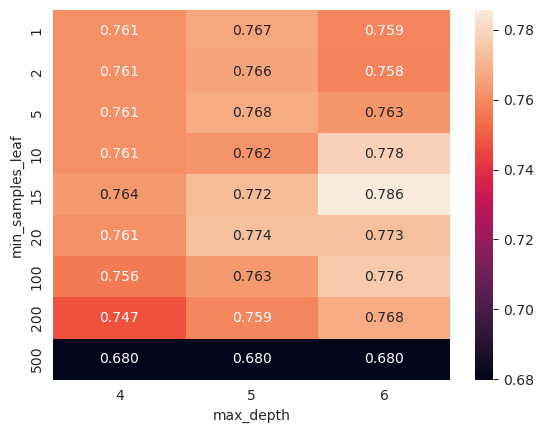

In [66]:
sns.heatmap(df_scores_pivot, annot=True, fmt='.3f')

In [67]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X=X_train, y=y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

In [68]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- records=no_rec <= 0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- price <= 925.00
|   |   |   |   |--- amount <= 525.00
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- amount >  525.00
|   |   |   |   |   |--- class: 1
|   |   |   |--- price >  925.00
|   |   |   |   |--- price <= 1382.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- price >  1382.00
|   |   |   |   |   |--- class: 0
|   |   |--- amount >  862.50
|   |   |   |--- assets <= 8250.00
|   |   |   |   |--- job=fixed <= 0.50
|   |   |   |   |   |--- assets <= 3425.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- assets >  3425.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- job=fixed >  0.50
|   |   |   |   |   |--- age <= 31.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- age >  31.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |--- assets >  8250.00
|   |   |   |   |--- income <= 132.50
|   |   |   |   |   |--- class:

## 6.6 Ensembles and random forest
* Board of experts
* Ensembling models
* Random forest - ensembling decision trees
* Tuning random forest

In [69]:
from sklearn.ensemble import RandomForestClassifier

In [70]:
rf = RandomForestClassifier(n_estimators=10, random_state=1)
rf.fit(X=X_train, y=y_train)

RandomForestClassifier(n_estimators=10, random_state=1)

In [71]:
y_pred = rf.predict_proba(X=X_val)[:,1]
roc_auc_score(y_true=y_val, y_score=y_pred)

0.7744726453706618

In [72]:
scores = []
for n_estimators in range(10,201,10):
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=1)
    rf.fit(X=X_train, y=y_train)
    
    y_pred = rf.predict_proba(X=X_val)[:,1]
    auc = roc_auc_score(y_true=y_val, y_score=y_pred)
    scores.append((n_estimators, auc))

Text(0.5, 1.0, "AUC en fonction du nombre d'estimateurs")

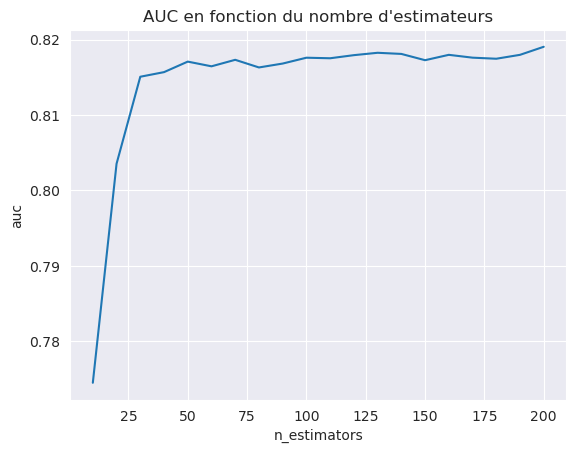

In [77]:
df_scores = pd.DataFrame(data=scores, columns=['n_estimators', 'auc'])
plt.plot(df_scores.n_estimators, df_scores.auc)
plt.xlabel('n_estimators')
plt.ylabel('auc')
plt.title('AUC en fonction du nombre d\'estimateurs')

In [78]:
scores = []
for max_depth in [5, 10, 15]:
    for n_estimators in range(10,201,10):
        rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=1)
        rf.fit(X=X_train, y=y_train)
        
        y_pred = rf.predict_proba(X=X_val)[:,1]
        auc = roc_auc_score(y_true=y_val, y_score=y_pred)
        scores.append((max_depth, n_estimators, auc))

In [79]:
df_scores = pd.DataFrame(data=scores, columns=['max_depth', 'n_estimators', 'auc'])
df_scores

,max_depth,n_estimators,auc
0,5,10,0.787699
1,5,20,0.797731
2,5,30,0.800305
3,5,40,0.799708
4,5,50,0.799878
5,5,60,0.801167
6,5,70,0.802251
7,5,80,0.803244
8,5,90,0.803616
9,5,100,0.804452


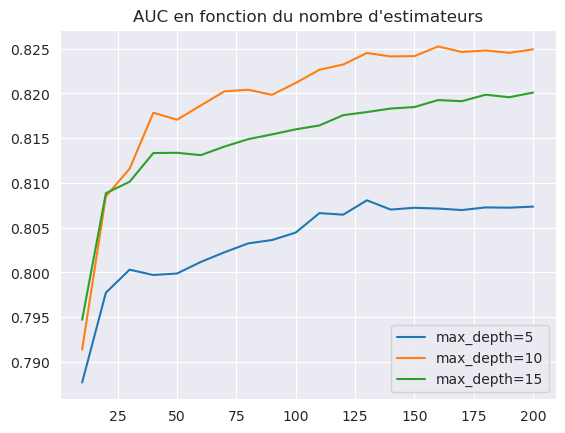

In [80]:
for max_depth in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == max_depth]
    plt.plot(df_subset.n_estimators, df_subset.auc, label='max_depth=%s' % max_depth)
    plt.legend()
    plt.title('AUC en fonction du nombre d\'estimateurs')

In [ ]:
max_depth = 10

In [81]:
scores = []
for min_samples_leaf in [1, 3, 5, 10, 50]:
    for n_estimators in range(10,201,10):
        rf = RandomForestClassifier(n_estimators=n_estimators,
                                    max_depth=max_depth,
                                    min_samples_leaf=min_samples_leaf,
                                    random_state=1)
        rf.fit(X=X_train, y=y_train)
        
        y_pred = rf.predict_proba(X=X_val)[:,1]
        auc = roc_auc_score(y_true=y_val, y_score=y_pred)
        scores.append((min_samples_leaf, n_estimators, auc))

In [82]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(data=scores, columns=columns)
df_scores

,min_samples_leaf,n_estimators,auc
0,1,10,0.794704
1,1,20,0.808848
2,1,30,0.810128
3,1,40,0.813337
4,1,50,0.813364
...,...,...,...
95,50,160,0.805844
96,50,170,0.805263
97,50,180,0.805433
98,50,190,0.805511


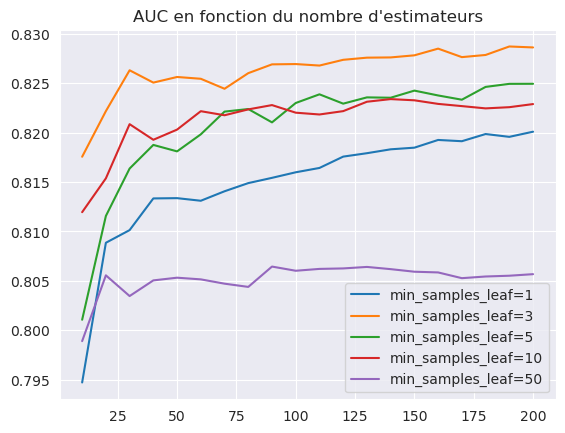

In [83]:
for min_samples_leaf in [1, 3, 5, 10, 50]:
    df_subset = df_scores[df_scores.min_samples_leaf == min_samples_leaf]
    plt.plot(df_subset.n_estimators, df_subset.auc, label='min_samples_leaf=%s' % min_samples_leaf)
    plt.legend()
    plt.title('AUC en fonction du nombre d\'estimateurs')